# 7).  Plot Iono Delay computed from dual frequency measures. 1 satellite
###3 Stations : Low, Medium, High latitudes. Two Cases:
<p>Jan 01-31 2009 (low solar activity)    Days 1-7  & May 01-31 2014 (high solar activity)  Days 121-127
<br>Plot 1 week during the month, compute iono delay prediction error metrics per hour of day. </p>
Estaciones Canada (flin), Madrid (madr), Galapagos (glps)
<br>- Compute Iono delay with code or phase:
<img  src="ionofreecombination.png">

In [194]:
import numpy as np
import gpstk
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline


def compute_ionodelay(nfiles,ofiles,strsat=None): #one week data
    f1=gpstk.L1_FREQ_GPS
    f2=gpstk.L2_FREQ_GPS
    Id_code=[] #Iono delay on Code 
    Id_phase=[] #Iono delay on Phase
    l,p=[],[]  # corrected l= Delay-free Phase; p=Delay-free phase
    to=[] #time of observations
    p1,p2=[],[] #Just pseudoranges P1 and P2 from rinex .o file
    p1err,p2err=[],[] #difference between pseudoranges and range computed with double frequency
    for i in range(len(nfiles)):  
        oheader,odata=gpstk.readRinex3Obs(ofiles[i],strict=True) 
        nheader,ndata=gpstk.readRinex3Nav(nfiles[i])
        for observation in odata:
            obs_types = np.array([i for i in oheader.R2ObsTypes])
            if "P1" and "P2" and "L1" and "L2" in obs_types:
                P1_idx = np.where(obs_types=="P1")[0][0] 
                P2_idx = np.where(obs_types=="P2")[0][0]
                L1_idx = np.where(obs_types=="L1")[0][0]
                L2_idx = np.where(obs_types=="L2")[0][0]
                sats=[satID for satID, datumList in observation.obs.iteritems() if str(satID).split()[0]=="GPS" ] 
                
                if strsat==None:  #Return for all satellites
                    for sat in sats:
                        time=observation.time
                        R1=observation.getObs(sat, P1_idx).data #pseudoranges
                        R2=observation.getObs(sat, P2_idx).data
                        L1=observation.getObs(sat, L1_idx).data*gpstk.L1_WAVELENGTH_GPS #L1 and L2 cicles
                        L2=observation.getObs(sat, L2_idx).data*gpstk.L2_WAVELENGTH_GPS

                        # #Compute iono-delay on phase and code
                        alfa=1/((f1**2/f2**2)-1)
                        iono_delay_c=alfa*(R2-R1) #delay on code
                        Id_code.append(iono_delay_c)
                        iono_delay_p=alfa*(L2-L1) #delay on phase
                        Id_phase.append(iono_delay_p)
                        p1.append(R1)
                        p2.append(R2)
                        # #delayfree code and phase
                        R= (R1*(f1**2)-R2*(f2**2))/(f1**2-f2**2)
                        L= (L1*(f1**2)-L2*(f2**2))/(f1**2-f2**2)
                        p.append(R)
                        l.append(L)
                        p1err.append(np.abs(R1-R))
                        p2err.append(np.abs(R2-R))
                        to.append(gpstk.GPSWeekSecond(time).sow)
                    
                else:   #Return for a specific satellite
                    for sat in sats:
                        if  str(sat)==strsat :
                            time=observation.time
                            R1=observation.getObs(sat, P1_idx).data #pseudoranges
                            R2=observation.getObs(sat, P2_idx).data
                            L1=observation.getObs(sat, L1_idx).data*gpstk.L1_WAVELENGTH_GPS #L1 and L2 cicles
                            L2=observation.getObs(sat, L2_idx).data*gpstk.L2_WAVELENGTH_GPS

                            # #Compute iono-delay on phase and code
                            alfa=1/((f1**2/f2**2)-1)
                            iono_delay_c=alfa*(R2-R1) #delay on code
                            Id_code.append(iono_delay_c)
                            iono_delay_p=alfa*(L2-L1) #delay on phase
                            Id_phase.append(iono_delay_p)
                            p1.append(R1)
                            p2.append(R2)
                            # #delayfree code and phase
                            R= (R1*(f1**2)-R2*(f2**2))/(f1**2-f2**2)
                            L= (L1*(f1**2)-L2*(f2**2))/(f1**2-f2**2)
                            p.append(R)
                            l.append(L)
                            p1err.append(np.abs(R1-R))
                            p2err.append(np.abs(R2-R))
                            to.append(gpstk.GPSWeekSecond(time).sow)
                        
            else:
                print "Needs both L1 and L2 frequencies to compute delay"
                break
    
    return p,p1,p2,l,to,Id_code,Id_phase,p1err,p2err


In [195]:
def plot_delay(p,p1,p2,l,to,Idc,Idp,p1err,p2err):
    plt.figure(figsize=(30,30))
    plt.subplot(6,1,1)
    plt.title("Iono-delay on code")
    plt.scatter(to,Idc, s=1, alpha=.5, color="green",marker=".",label="Code")
    plt.xlabel("Time of week [seconds]")
    plt.ylabel("Delay [meters]")
    plt.subplot(6,1,2)
    plt.title("Iono-delay on phase")
    plt.scatter(to,Idp, s=1, alpha=.5, color="red",marker=".",label="Phase")
    plt.xlabel("Time of week [seconds]")
    plt.subplot(6,1,3)
    plt.title("Delay-free Code")
    plt.scatter(to,p, s=1, alpha=.5, color="green",marker=".",label="Code")
    #red and green are the same!
    plt.scatter(to,p1, s=1, alpha=.5, color="red",marker=".",label="Code")
    plt.scatter(to,p2, s=1, alpha=.5, color="blue",marker=".",label="Code")
    plt.xlabel("Time of week [seconds]")
    plt.ylabel("Range [meters]")
    plt.subplot(6,1,4)
    plt.title("Delay-free Phase")
    plt.scatter(to,l, s=1, alpha=.5, color="blue",marker=".",label="Phase")
    
    plt.subplot(6,1,5)
    plt.title("P1 error compared to Range computed with double freque")
    plt.scatter(to,p1err, s=1, alpha=.5, color="blue",marker=".",label="Phase")
    
    plt.subplot(6,1,6)
    plt.title("P2 error compared to Range computed with double freque")
    plt.scatter(to,p2err, s=1, alpha=.5, color="blue",marker=".",label="Phase")
    plt.legend()


Times observed from:  0.0 to:  604770.0  [Seconds of week]
Canada 2009
Mean error in P1:  0.79763972322
Mean error in P2:  1.3136683108


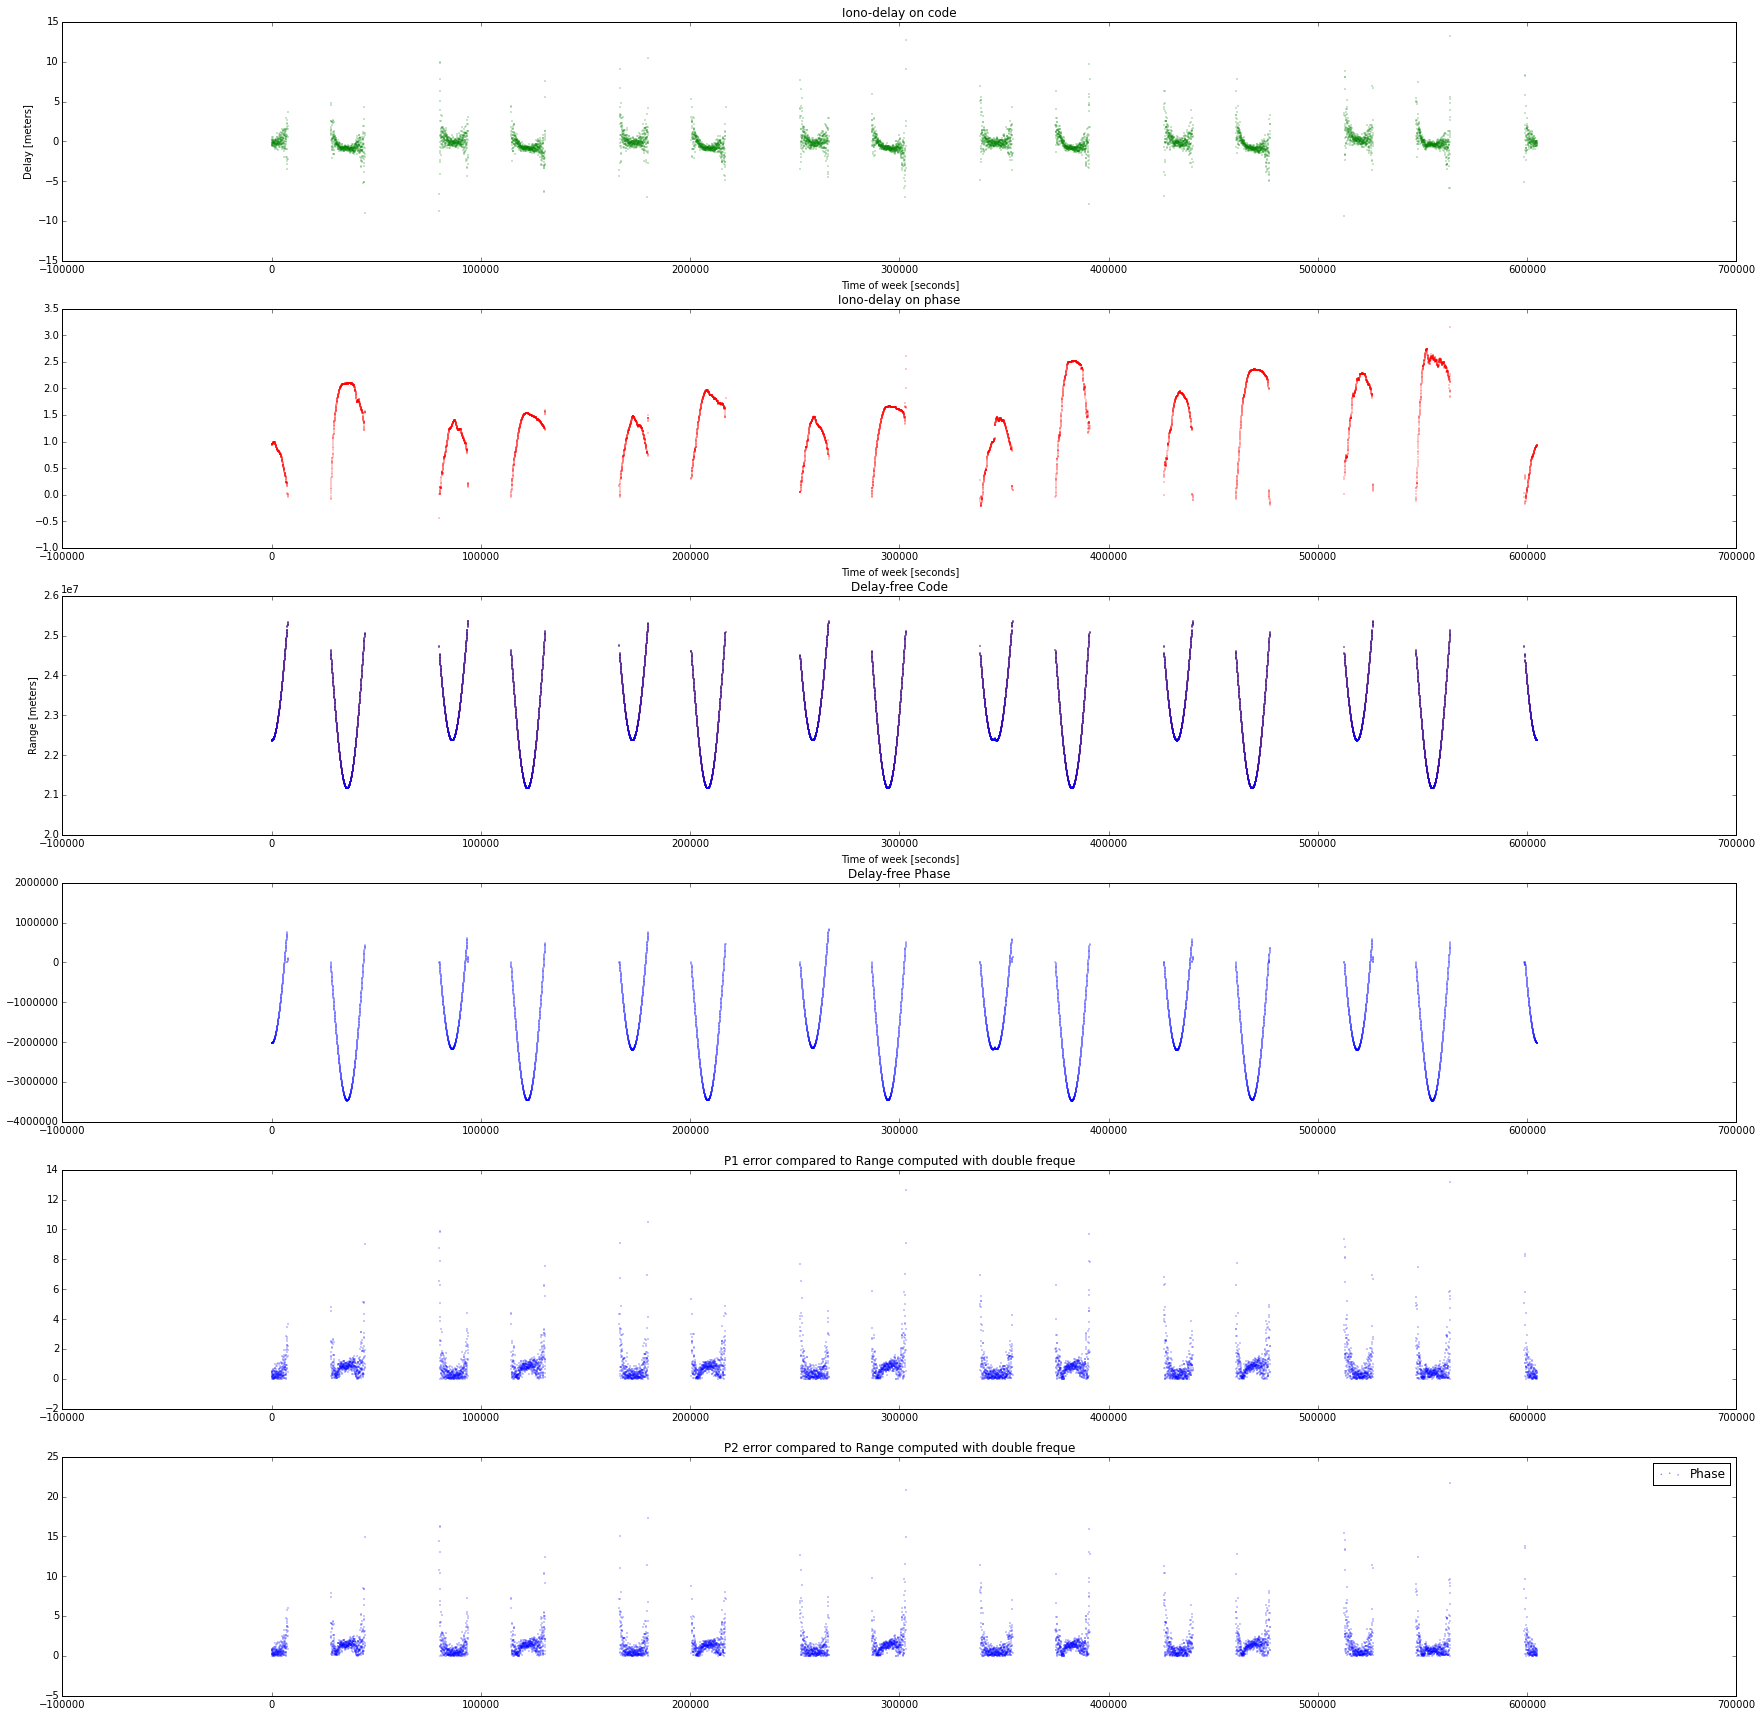

In [196]:
nfiles=[]
ofiles=[]

for i in range(1,8):
    n="/mnt/flin00"+str(i)+"0.09n"
    o="/mnt/flin00"+str(i)+"0.09o"
    nfiles.append(n)
    ofiles.append(o)
    
strsat="GPS 3"
p,p1,p2,l,to,Idc,Idp,p1err,p2err=compute_ionodelay(nfiles,ofiles,strsat)
print "Times observed from: ",np.min(to),"to: ",np.max(to)," [Seconds of week]"
print "Canada 2009"
plot_delay(p,p1,p2,l,to,Idc,Idp,p1err,p2err)
print "Mean error in P1: ",np.mean(p1err)
print "Mean error in P2: ",np.mean(p2err)

Canada 2014
Times observed from:  35460.0 to:  604320.0  [Seconds of week]
Mean error in P1:  2.96727073673
Mean error in P2:  4.88693005507


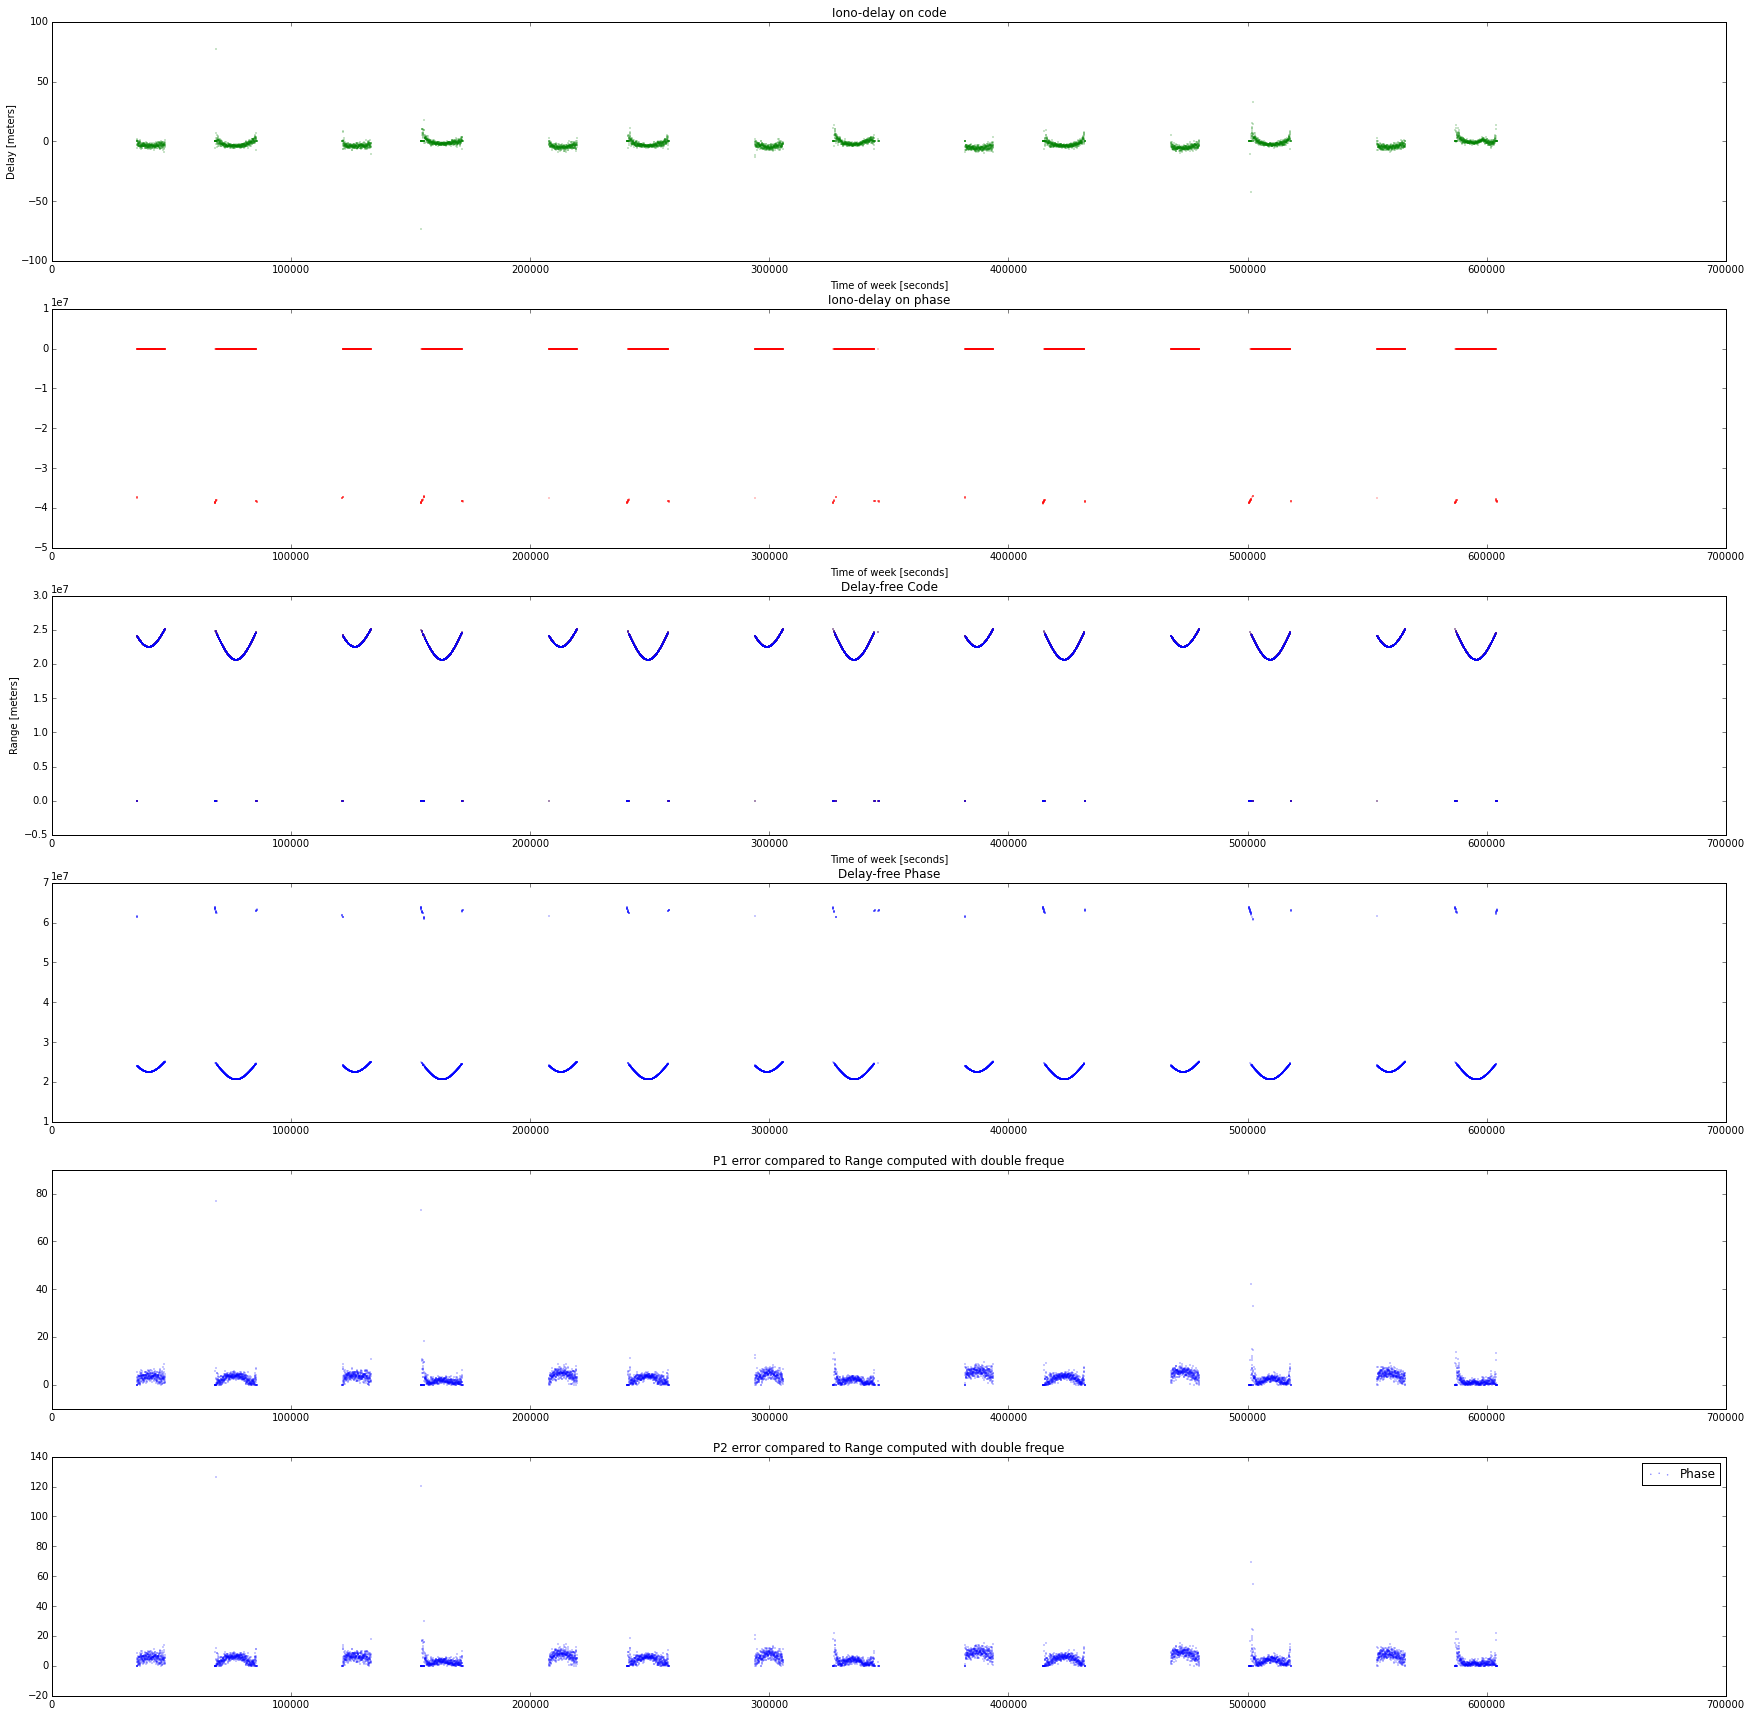

In [197]:
nfiles=[]
ofiles=[]

for i in range(121,128):
    n="/mnt/flin"+str(i)+"0.14n"
    o="/mnt/flin"+str(i)+"0.14o"
    nfiles.append(n)
    ofiles.append(o)
print "Canada 2014"
strsat="GPS 3"
p,p1,p2,l,to,Idc,Idp,p1err,p2err=compute_ionodelay(nfiles,ofiles,strsat)
print "Times observed from: ",np.min(to),"to: ",np.max(to)," [Seconds of week]"
plot_delay(p,p1,p2,l,to,Idc,Idp,p1err,p2err)
print "Mean error in P1: ",np.mean(p1err)
print "Mean error in P2: ",np.mean(p2err)

Times observed from:  0.0 to:  604770.0  [Seconds of week]
Madrid 2009
Mean error in P1:  5.89524345209
Mean error in P2:  9.70913845209


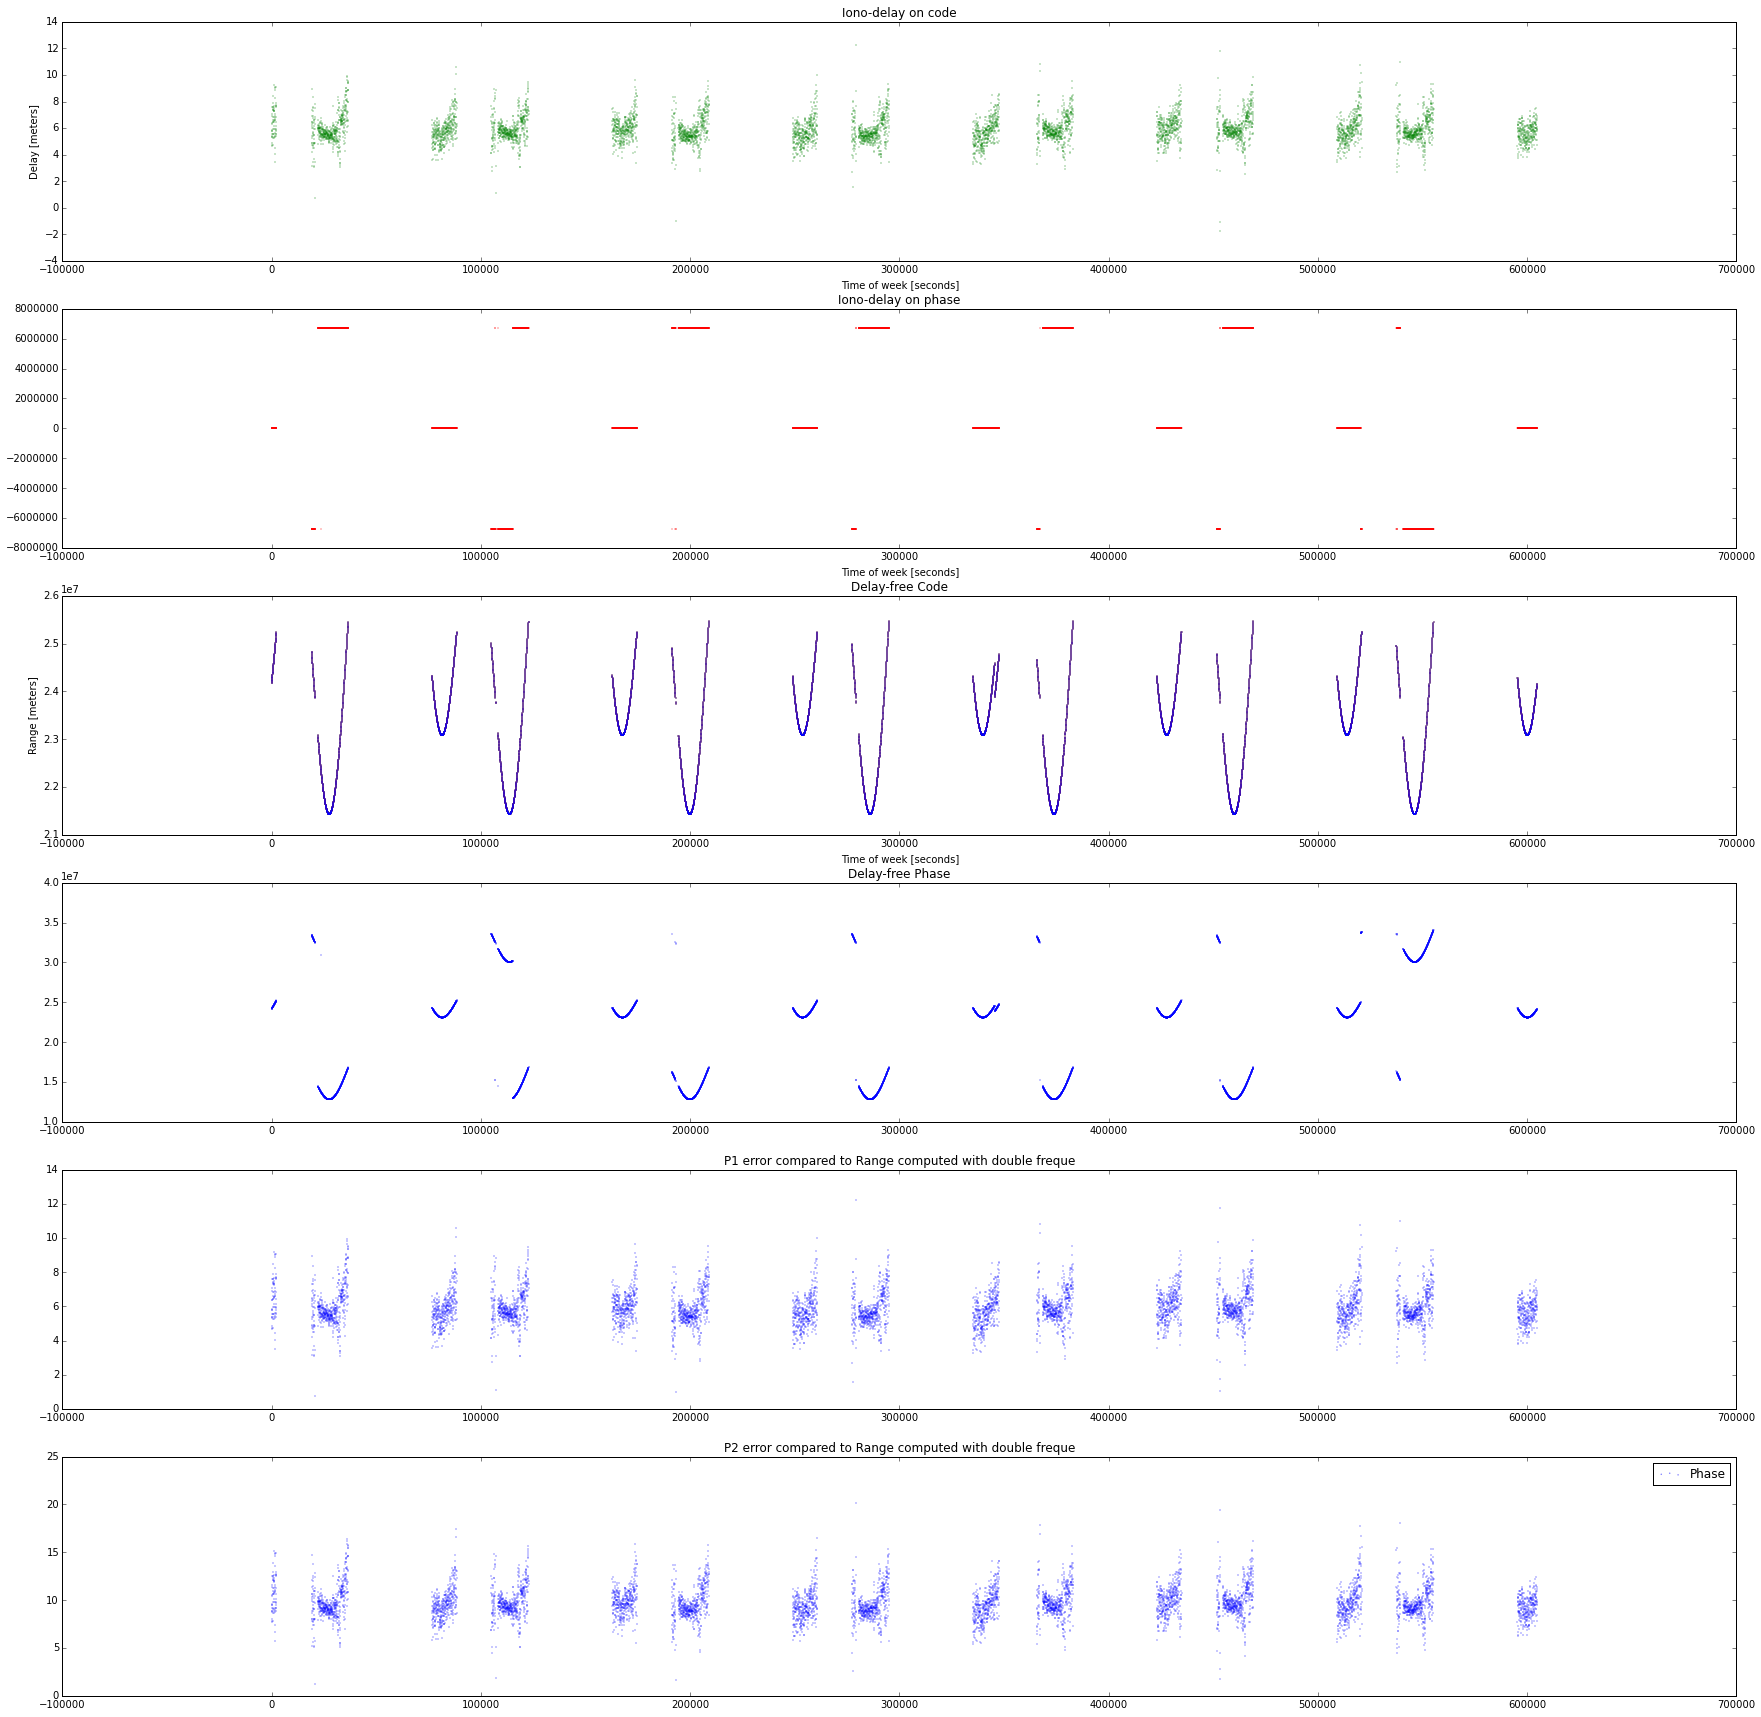

In [198]:
nfiles=[]
ofiles=[]

for i in range(1,8):
    n="/mnt/madr00"+str(i)+"0.09n"
    o="/mnt/madr00"+str(i)+"0.09o"
    nfiles.append(n)
    ofiles.append(o)

strsat="GPS 24"
p,p1,p2,l,to,Idc,Idp,p1err,p2err=compute_ionodelay(nfiles,ofiles,strsat)
print "Times observed from: ",np.min(to),"to: ",np.max(to)," [Seconds of week]"
print "Madrid 2009"
plot_delay(p,p1,p2,l,to,Idc,Idp,p1err,p2err)
print "Mean error in P1: ",np.mean(p1err)
print "Mean error in P2: ",np.mean(p2err)

Madrid 2014
Times observed from:  36090.0 to:  580890.0  [Seconds of week]
Mean error in P1:  8.31902051247
Mean error in P2:  13.7009646162


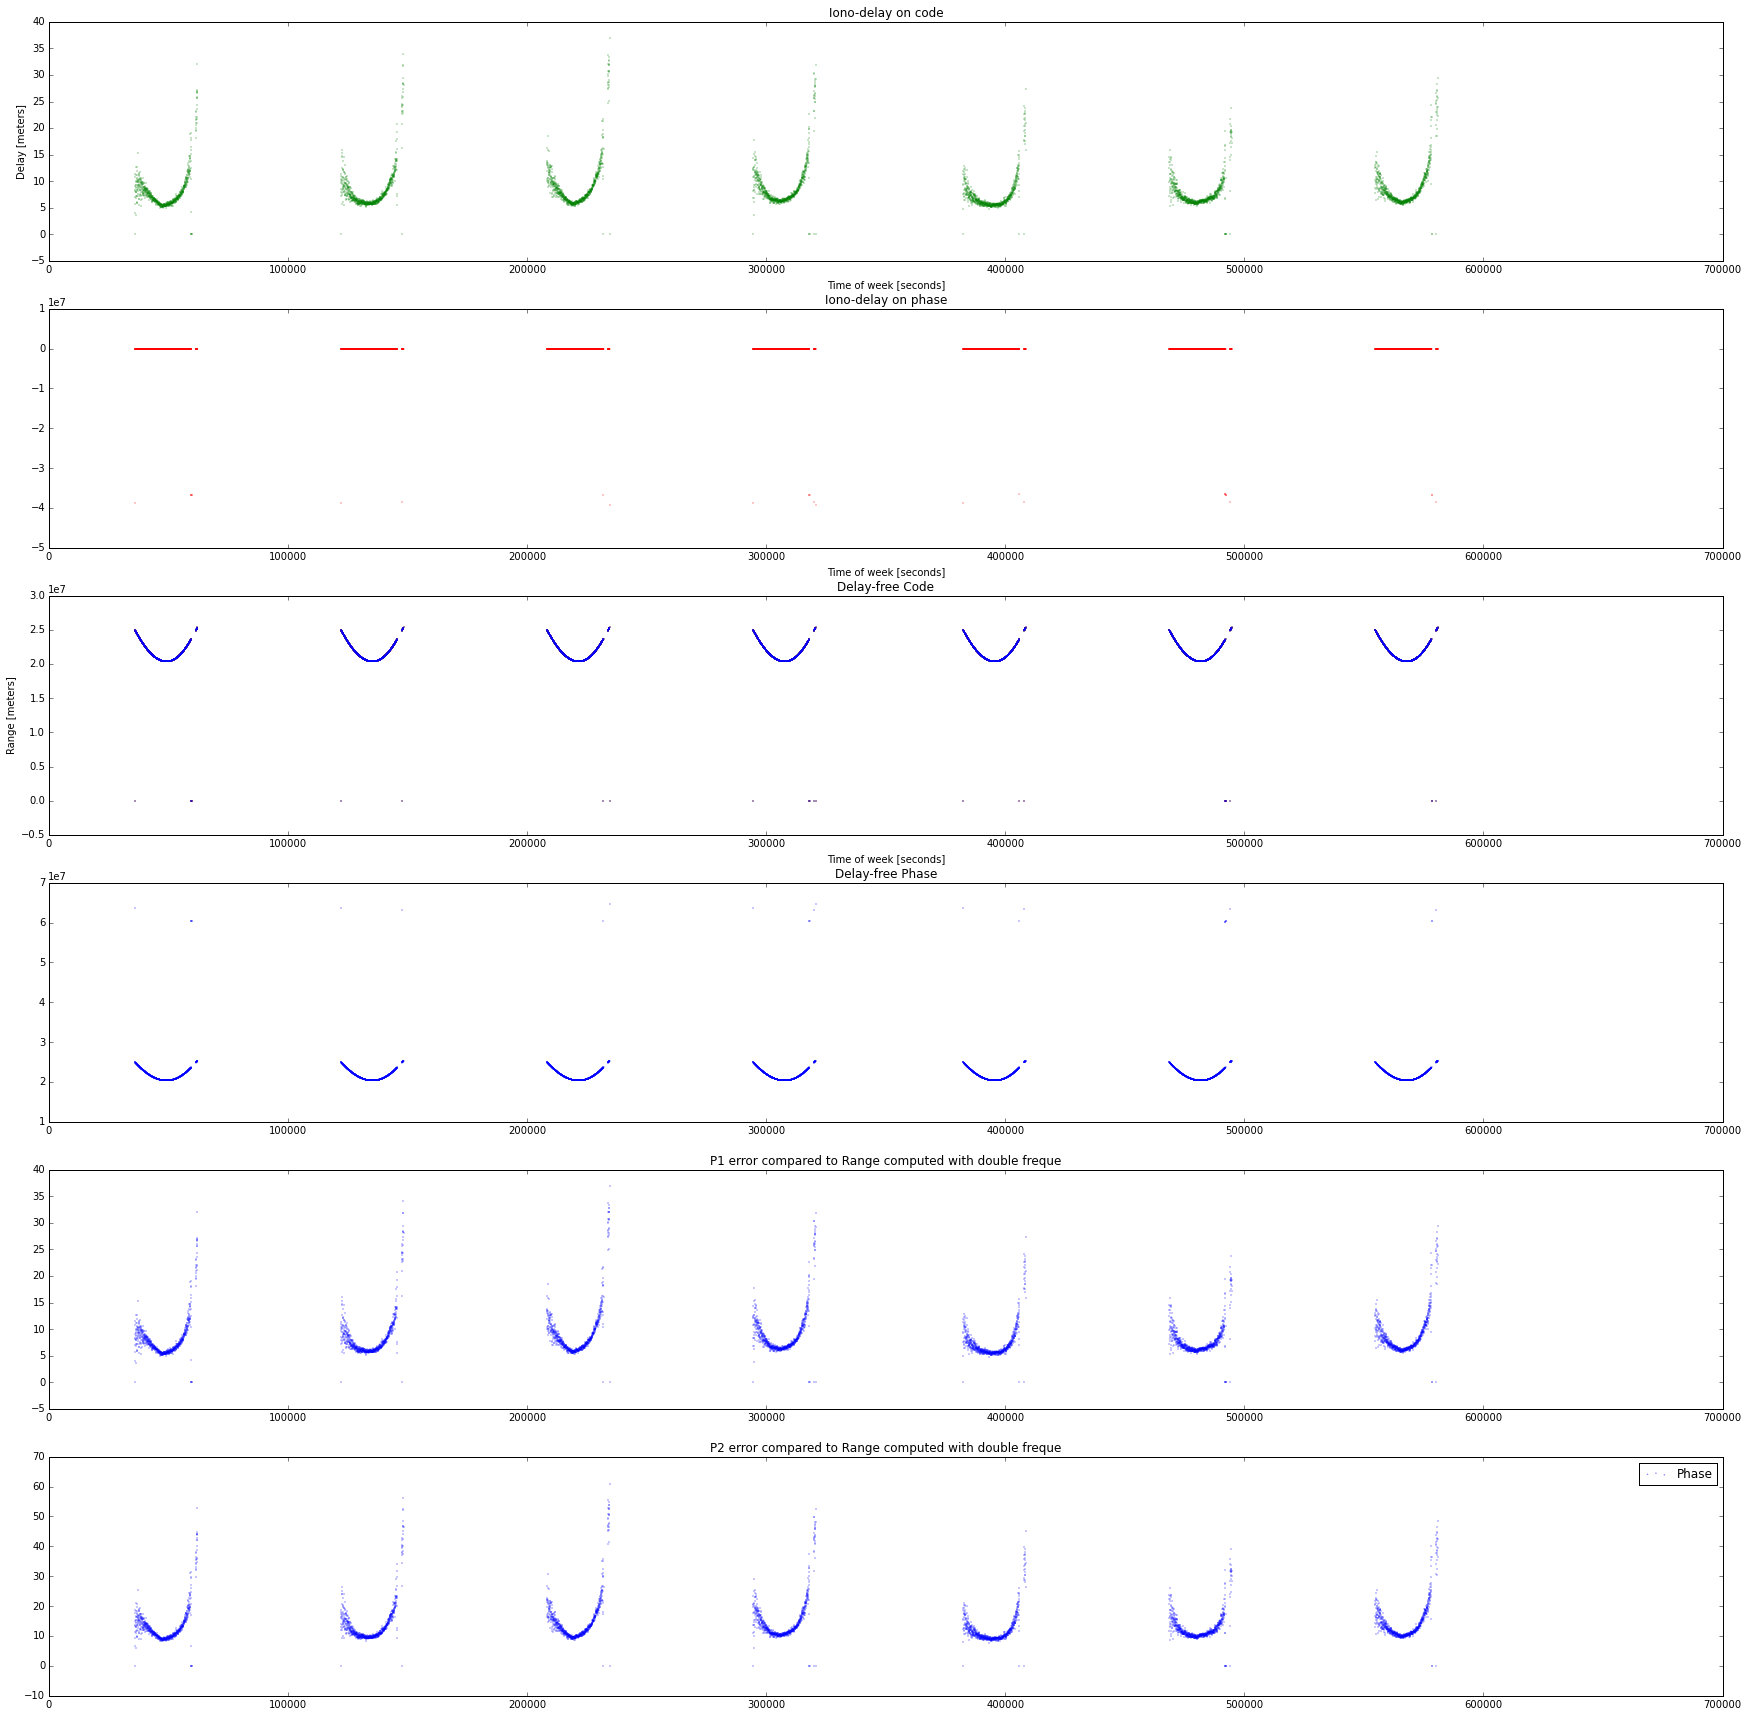

In [199]:
nfiles=[]
ofiles=[]

for i in range(121,128):
    n="/mnt/madr"+str(i)+"0.14n"
    o="/mnt/madr"+str(i)+"0.14o"
    nfiles.append(n)
    ofiles.append(o)
print "Madrid 2014"
strsat="GPS 24"
p,p1,p2,l,to,Idc,Idp,p1err,p2err=compute_ionodelay(nfiles,ofiles,strsat)
print "Times observed from: ",np.min(to),"to: ",np.max(to)," [Seconds of week]"
plot_delay(p,p1,p2,l,to,Idc,Idp,p1err,p2err)
print "Mean error in P1: ",np.mean(p1err)
print "Mean error in P2: ",np.mean(p2err)

Galapagos 2009
Times observed from:  20880.0 to:  574470.0  [Seconds of week]
Mean error in P1:  4.84140701502
Mean error in P2:  7.97352838672


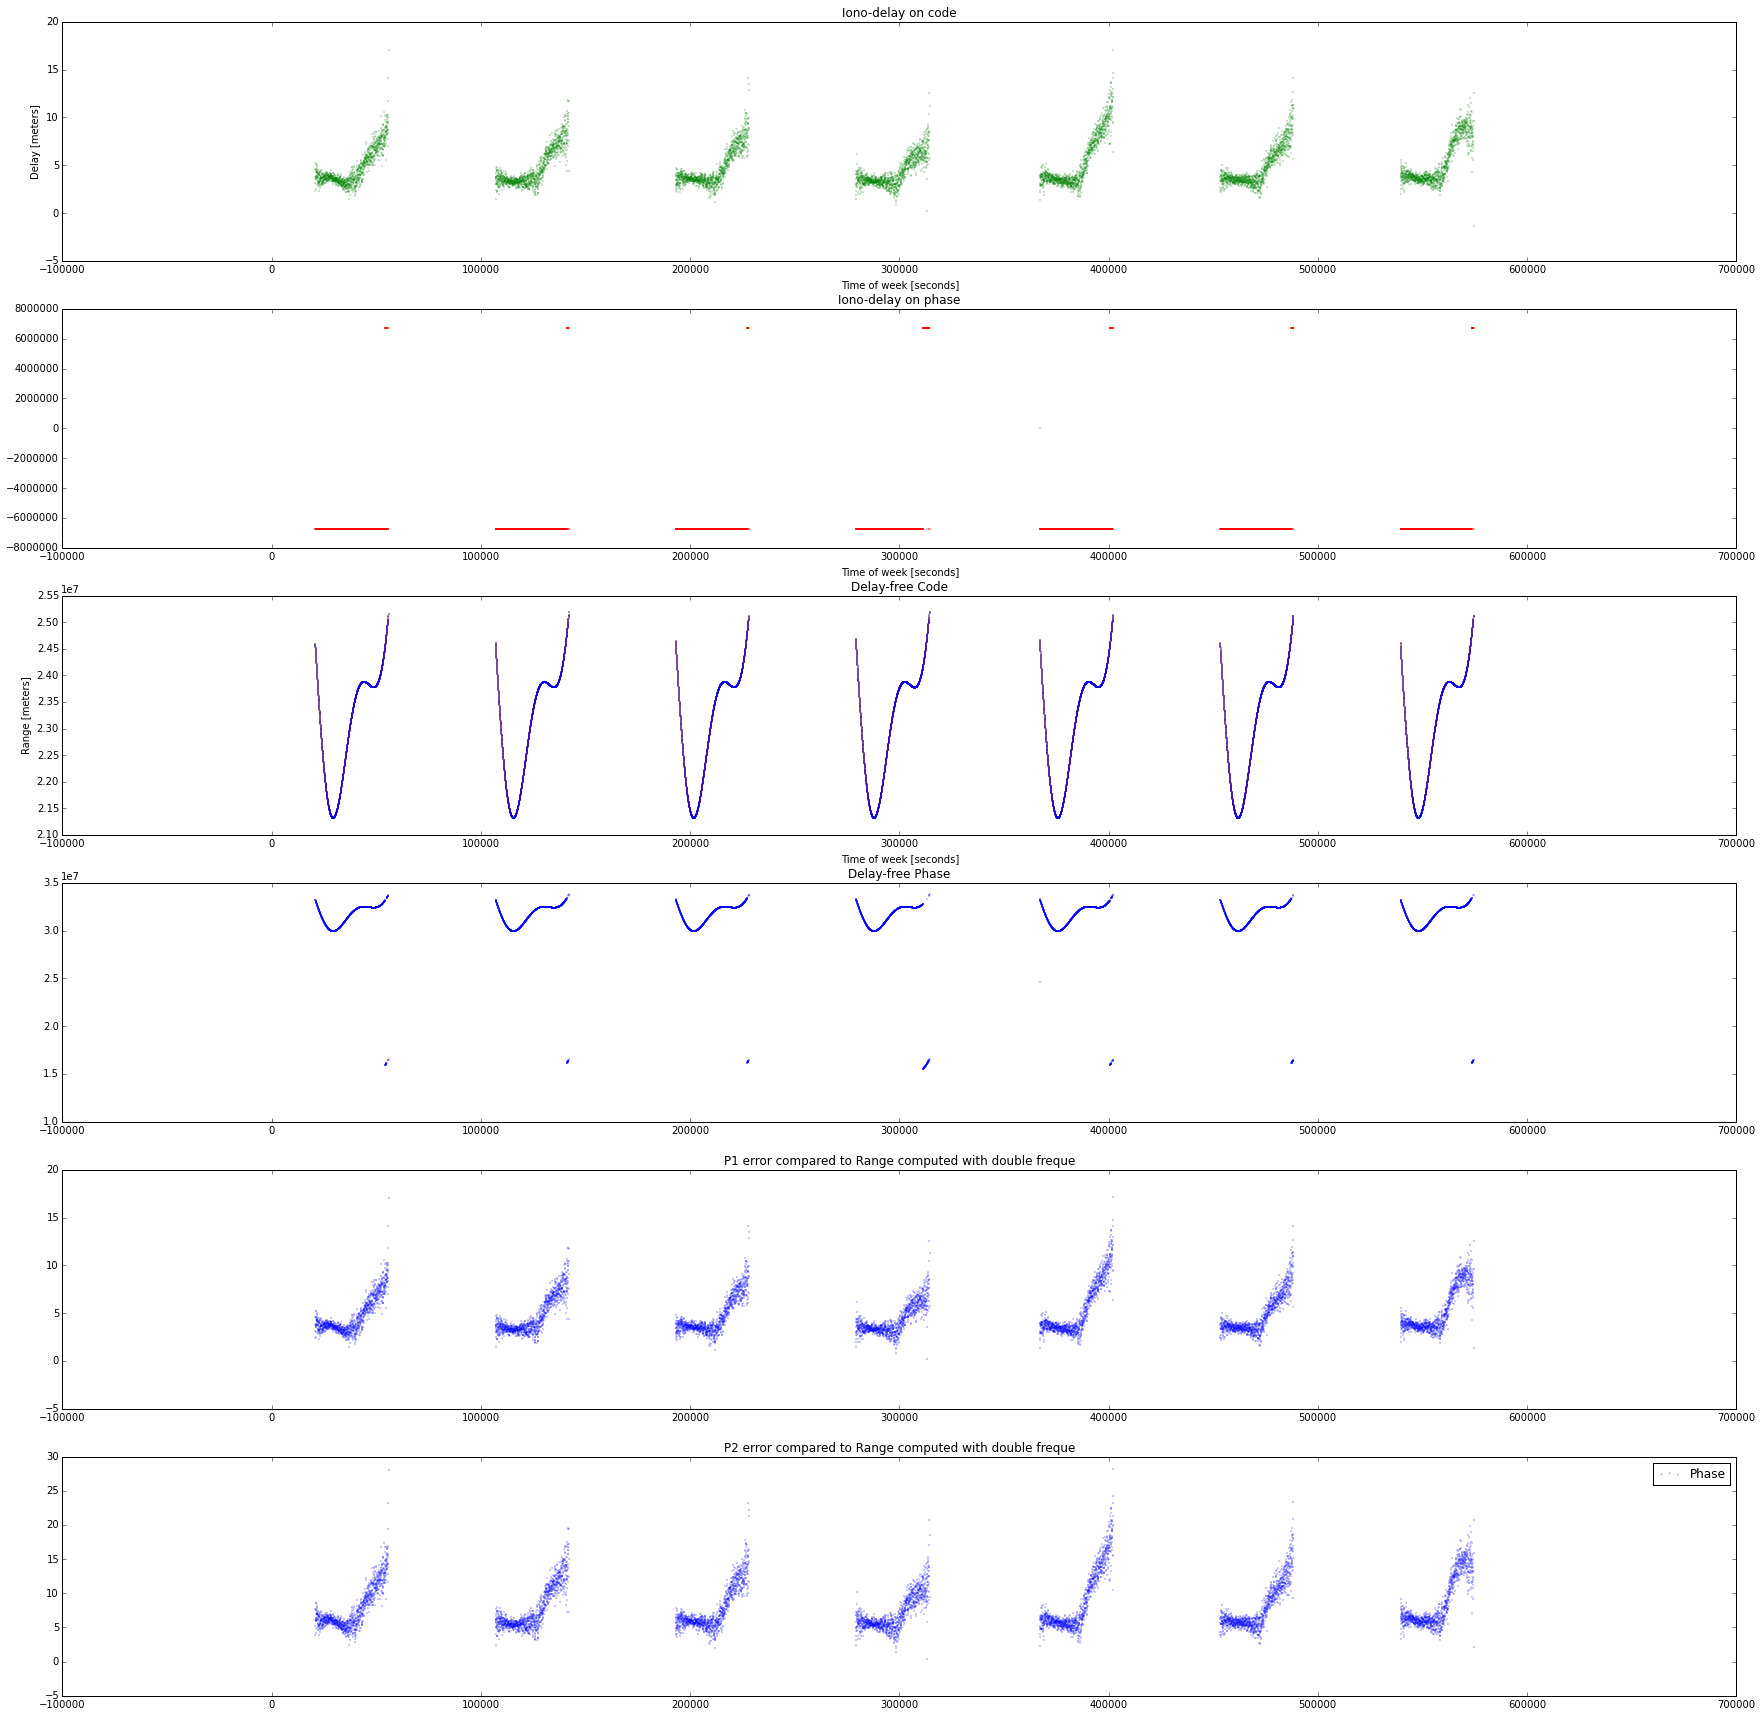

In [200]:
nfiles=[]
ofiles=[]

for i in range(1,8):
    n="/mnt/glps00"+str(i)+"0.09n"
    o="/mnt/glps00"+str(i)+"0.09o"
    nfiles.append(n)
    ofiles.append(o)
strsat="GPS 20"
p,p1,p2,l,to,Idc,Idp,p1err,p2err=compute_ionodelay(nfiles,ofiles,strsat)
print "Galapagos 2009"
print "Times observed from: ",np.min(to),"to: ",np.max(to)," [Seconds of week]"
plot_delay(p,p1,p2,l,to,Idc,Idp,p1err,p2err)
print "Mean error in P1: ",np.mean(p1err)
print "Mean error in P2: ",np.mean(p2err)

Galapagos 2014
Times observed from:  0.0 to:  604770.0  [Seconds of week]
Mean error in P1:  15.1344974973
Mean error in P2:  24.9256765727


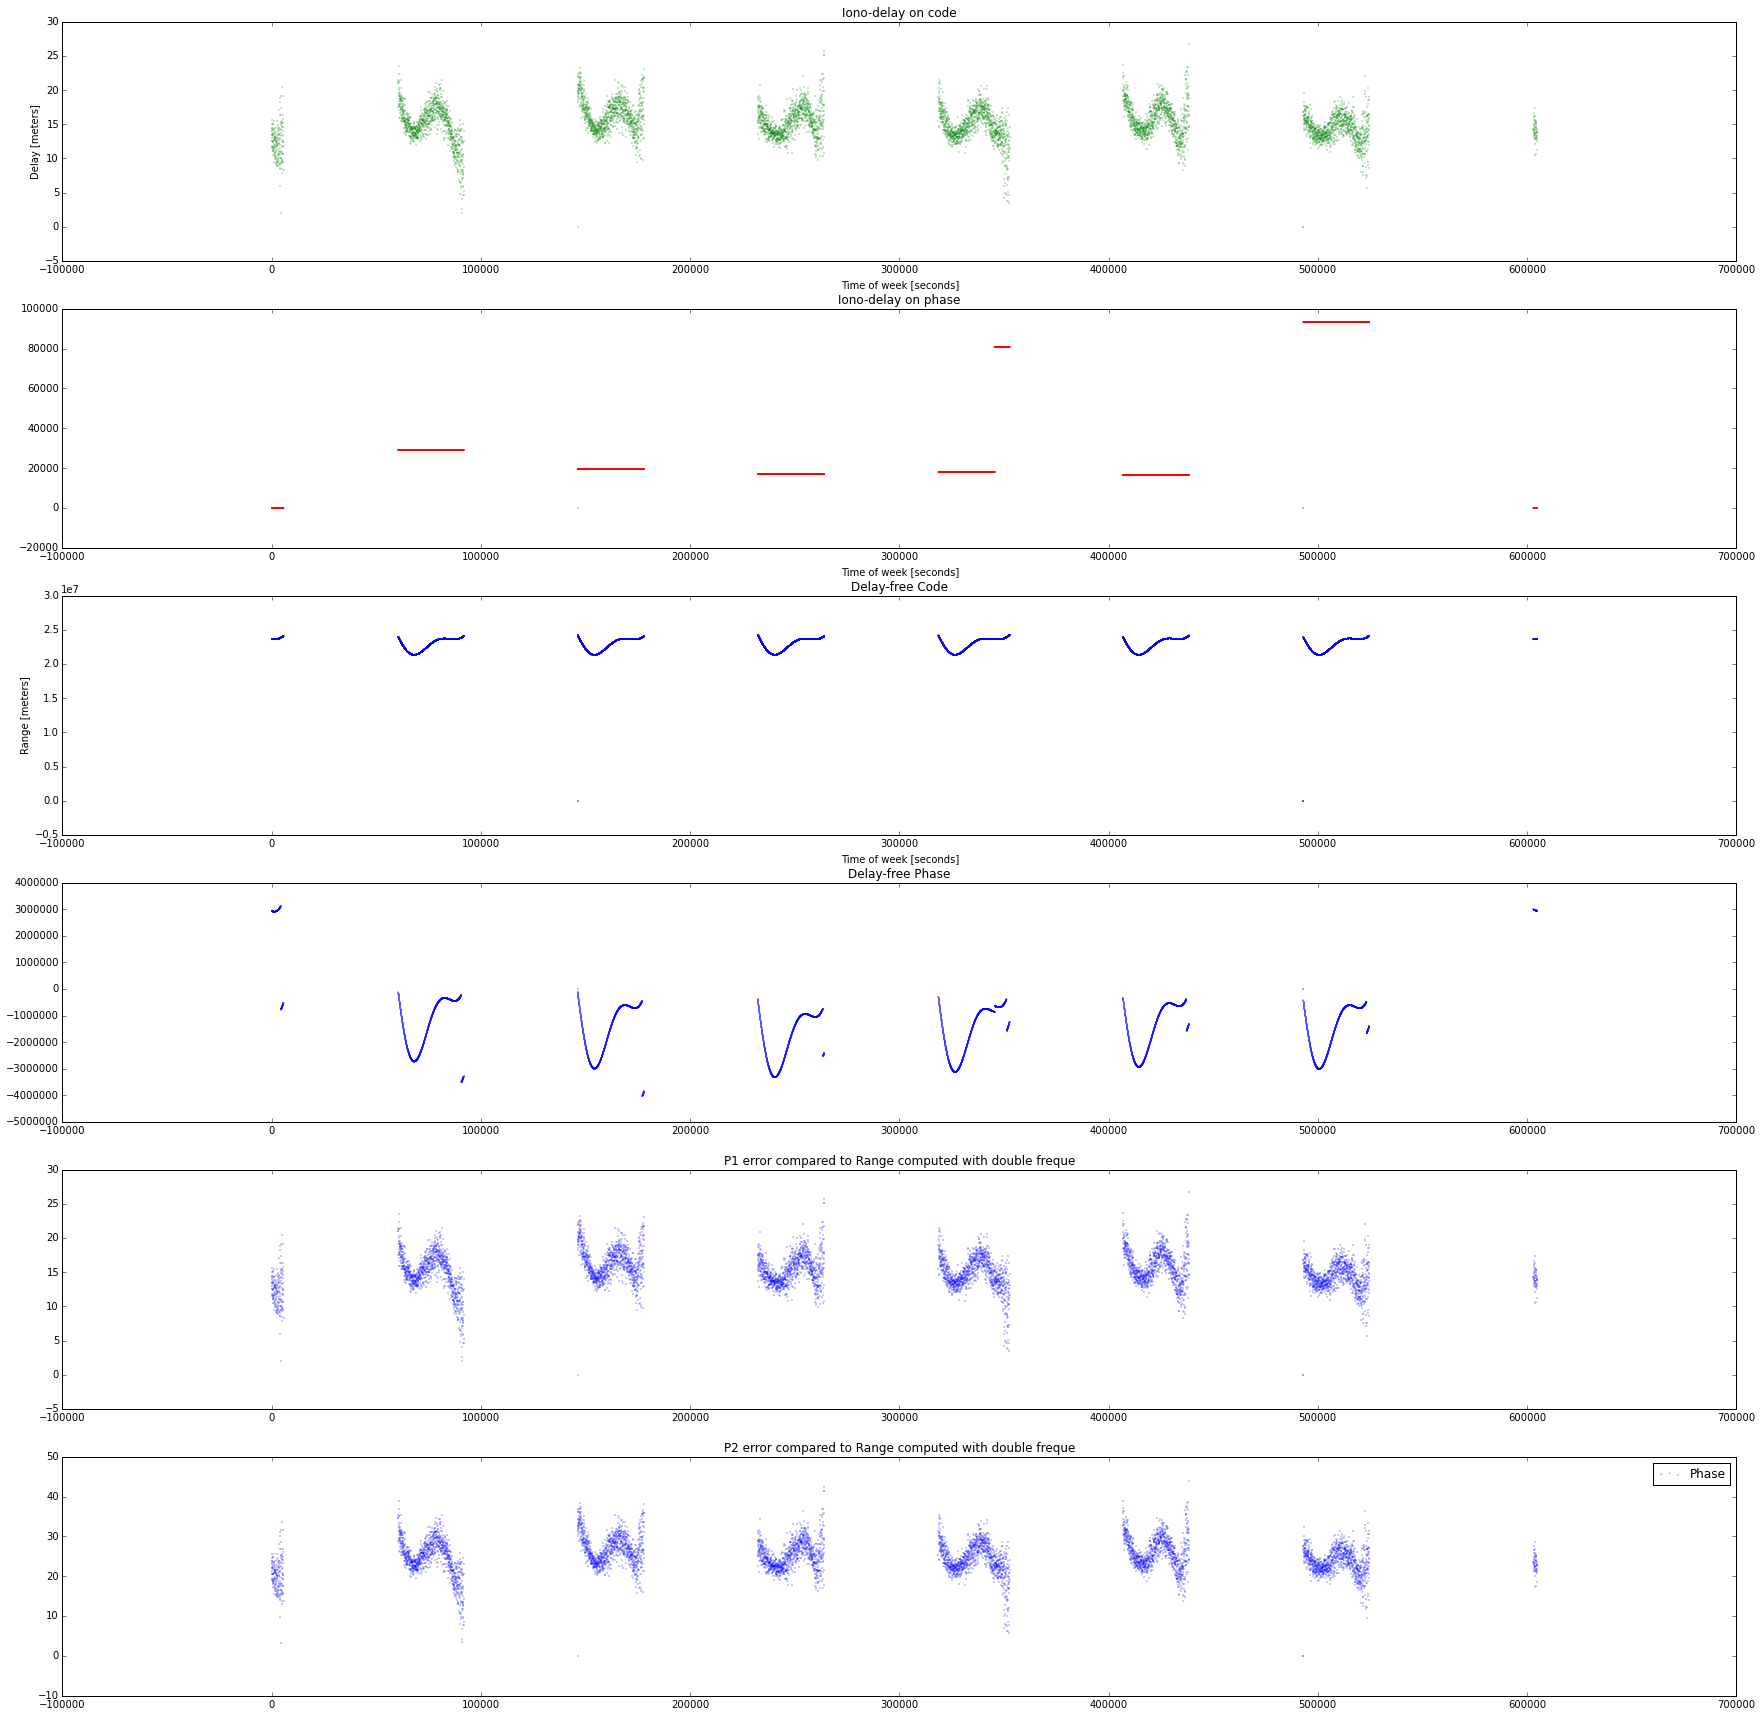

In [201]:
nfiles=[]
ofiles=[]

for i in range(121,128):
    n="/mnt/glps"+str(i)+"0.14n"
    o="/mnt/glps"+str(i)+"0.14o"
    nfiles.append(n)
    ofiles.append(o)
strsat="GPS 20"
p,p1,p2,l,to,Idc,Idp,p1err,p2err=compute_ionodelay(nfiles,ofiles,strsat)
print "Galapagos 2014"
print "Times observed from: ",np.min(to),"to: ",np.max(to)," [Seconds of week]"
plot_delay(p,p1,p2,l,to,Idc,Idp,p1err,p2err)
print "Mean error in P1: ",np.mean(p1err)
print "Mean error in P2: ",np.mean(p2err)

#8). Same stations, plot iono delay predicted by Klobuchar from L1.


It is assumed that the electron content is concentrated in a thin layer at kilometres in height. Thence, the slant delay is computed from the vertical delay at the Ionospheric Pierce Point (IPP) multiplying by a obliquity factor (taken from <a href="http://www.navipedia.net/index.php/Klobuchar_Ionospheric_Model">here</a>)

In [216]:
import numpy as np
import gpstk
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

def klobuchar(obs,nav,strsat=None):
    ohead,odata=gpstk.readRinex3Obs(obs)
    nhead,ndata=gpstk.readRinex3Nav(nav)
    n=gpstk.readRinexNav(nav) #from this nav header we get klobuchar coeficients
    times=[] #times observed
    d=[]#iono delay
    
    bcestore = gpstk.GPSEphemerisStore() 
    for ndato in ndata:
        ephem = ndato.toGPSEphemeris()
        bcestore.addEphemeris(ephem)
    bcestore.SearchNear() 
    
    for observation in odata:
        sats=[satID for satID,datumList in observation.obs.iteritems()if str(satID).split()[0]=="GPS"]
        #for sat in sats:
            #print "Sat ",sat
        if len(sats)!=0:
            if strsat!=None: #Return for specific satellite
                for sat in sats:
                    if str(sat)==strsat:
                        eph = bcestore.findEphemeris(sat, observation.time) 
                        sat_pos = eph.svXvt(observation.time)  
                        elev = ohead.antennaPosition.elvAngle(sat_pos.x)# elevation and azimut are measured in degrees
                        azim = ohead.antennaPosition.azAngle(sat_pos.x)
                        razim=azim*np.pi/180 #azimut to radians
                        relev=elev/180 #elevation in semicircles
                        rec_pos = gpstk.Position(ohead.antennaPosition[0], ohead.antennaPosition[1], ohead.antennaPosition[2])
                        geodetic_lat= rec_pos.geodeticLatitude()
                        longitude=rec_pos.getLongitude()
                        alpha=n[0].ionAlpha #Klobuchar's alpha & beta
                        beta=n[0].ionBeta
                        ec_angle=0.0137/(relev+0.11)  - 0.022 #earth centered angle
                        sgeodetic_lat=geodetic_lat/180 #geodetic latitude in semicircles
                        ipp_lat=sgeodetic_lat+ec_angle*np.cos(razim)
                        if ipp_lat>0.416:
                            ipp_lat=0.416
                        elif ipp_lat<-0.416:
                            ipp_lat=-0.416
                        slongitude=longitude/180 #longitude in semicircles
                        ipp_long=slongitude+((ec_angle*np.sin(razim))/(np.cos(ipp_lat)))
                        ipp_geomaglat=ipp_lat+0.064*np.cos(ipp_long-1.617)

                        t=43200*ipp_long+gpstk.GPSWeekSecond(observation.time).sow 
                        if t>=86400:
                            t-=86400
                        if t<0:
                            t+=86400

                        AI=0
                        for i in range(len(alpha)):
                            AI=AI+(alpha[i]*ipp_geomaglat**i) #Amplitude of ionospheric delay
                        if AI<0:
                            AI=0

                        PI=0
                        for i in range(len(beta)):
                            PI=PI+(beta[i]*ipp_geomaglat**i) #Period of ionospheric delay
                        if PI<72000:
                            PI=72000

                        XI=2*np.pi*(t-50400)/PI    #Phase iono-delay
                        F=1.0+16.0*(0.53-relev)**3 #Slant factor
                        g = lambda x: alpha[x]*(ipp_geomaglat**x)*(1-(XI**2/2)+(XI**4/24))

                        #Ionospheric time delay
                        if np.abs(XI)<=1.57:
                            IL1=5.10e-9+np.sum([g(i) for i in range(len(alpha)) ])*F
                        else:
                            IL1=5.10e-9*F

                        dIon=299792458*IL1
                        d.append(dIon)
                        times.append(gpstk.GPSWeekSecond(observation.time).sow)
            else: # Return for every satellite observed
                for sat in sats:
                    eph = bcestore.findEphemeris(sat, observation.time) 
                    sat_pos = eph.svXvt(observation.time)  
                    elev = ohead.antennaPosition.elvAngle(sat_pos.x)# elevation and azimut are measured in degrees
                    azim = ohead.antennaPosition.azAngle(sat_pos.x)
                    razim=azim*np.pi/180 #azimut to radians
                    relev=elev/180 #elevation in semicircles
                    rec_pos = gpstk.Position(ohead.antennaPosition[0], ohead.antennaPosition[1], ohead.antennaPosition[2])
                    geodetic_lat= rec_pos.geodeticLatitude()
                    longitude=rec_pos.getLongitude()
                    alpha=n[0].ionAlpha #Klobuchar's alpha & beta
                    beta=n[0].ionBeta
                    ec_angle=0.0137/(relev+0.11)  - 0.022 #earth centered angle
                    sgeodetic_lat=geodetic_lat/180 #geodetic latitude in semicircles
                    ipp_lat=sgeodetic_lat+ec_angle*np.cos(razim)
                    if ipp_lat>0.416:
                        ipp_lat=0.416
                    elif ipp_lat<-0.416:
                        ipp_lat=-0.416
                    slongitude=longitude/180 #longitude in semicircles
                    ipp_long=slongitude+((ec_angle*np.sin(razim))/(np.cos(ipp_lat)))
                    ipp_geomaglat=ipp_lat+0.064*np.cos(ipp_long-1.617)

                    t=43200*ipp_long+gpstk.GPSWeekSecond(observation.time).sow 
                    if t>=86400:
                        t-=86400
                    if t<0:
                        t+=86400

                    AI=0
                    for i in range(len(alpha)):
                        AI=AI+(alpha[i]*ipp_geomaglat**i) #Amplitude of ionospheric delay
                    if AI<0:
                        AI=0

                    PI=0
                    for i in range(len(beta)):
                        PI=PI+(beta[i]*ipp_geomaglat**i) #Period of ionospheric delay
                    if PI<72000:
                        PI=72000

                    XI=2*np.pi*(t-50400)/PI    #Phase iono-delay
                    F=1.0+16.0*(0.53-relev)**3 #Slant factor
                    g = lambda x: alpha[x]*(ipp_geomaglat**x)*(1-(XI**2/2)+(XI**4/24))

                    #Ionospheric time delay
                    if np.abs(XI)<=1.57:
                        IL1=5.10e-9+np.sum([g(i) for i in range(len(alpha)) ])*F
                    else:
                        IL1=5.10e-9*F

                    dIon=299792458*IL1
                    d.append(dIon)
                    times.append(gpstk.GPSWeekSecond(observation.time).sow)
                    
    return times,d
            

Delay in a day, one satellite


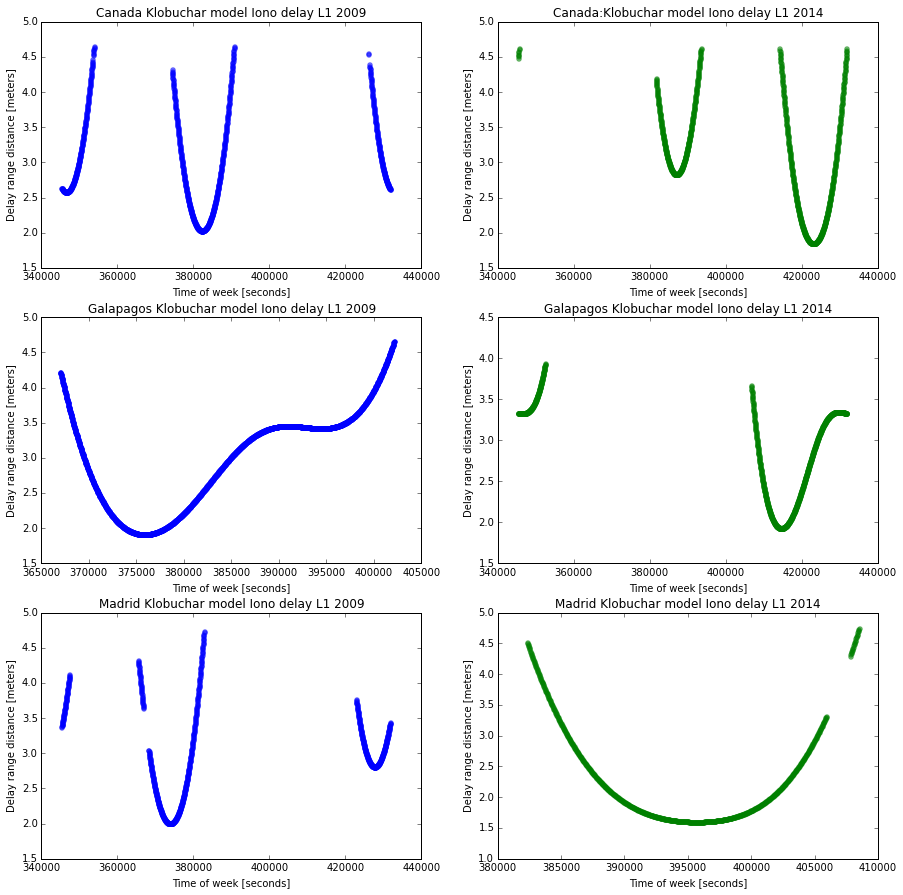

In [203]:
plt.figure(figsize=(15,15))
print "Delay in a day, one satellite"

obs="/mnt/flin0010.09o"
nav="/mnt/flin0010.09n"
strsat="GPS 3"
t,d=klobuchar(obs,nav,strsat)
plt.subplot(3,2,1)
title="Canada Klobuchar model Iono delay L1 2009"
plt.title(title)
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="blue",alpha=.5)

obs="/mnt/flin1210.14o"
nav="/mnt/flin1210.14n"
t,d=klobuchar(obs,nav,strsat)
plt.subplot(3,2,2)
title="Canada:Klobuchar model Iono delay L1 2014 "
plt.title(title)
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="green",alpha=0.5)

obs="/mnt/glps0010.09o"
nav="/mnt/glps0010.09n"
strsat="GPS 20"
t,d=klobuchar(obs,nav,strsat)
plt.subplot(3,2,3)
plt.title("Galapagos Klobuchar model Iono delay L1 2009")
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="blue")

obs="/mnt/glps1210.14o"
nav="/mnt/glps1210.14n"
t,d=klobuchar(obs,nav,strsat)
plt.subplot(3,2,4)
plt.title("Galapagos Klobuchar model Iono delay L1 2014")
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="green",alpha=.5)

obs="/mnt/madr0010.09o"
nav="/mnt/madr0010.09n"
strsat="GPS 24"
t,d=klobuchar(obs,nav,strsat)
plt.subplot(3,2,5)
plt.title("Madrid Klobuchar model Iono delay L1 2009")
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="blue",alpha=.5)

obs="/mnt/madr1210.14o"
nav="/mnt/madr1210.14n"
t,d=klobuchar(obs,nav,strsat)
plt.subplot(3,2,6)
plt.title("Madrid Klobuchar model Iono delay L1 2014")
plt.xlabel("Time of week [seconds]")
plt.ylabel("Delay range distance [meters]")
plt.scatter(t,d,color="green",alpha=.5)





##Comparing double frequency and klobuchar model on a day. One satelite

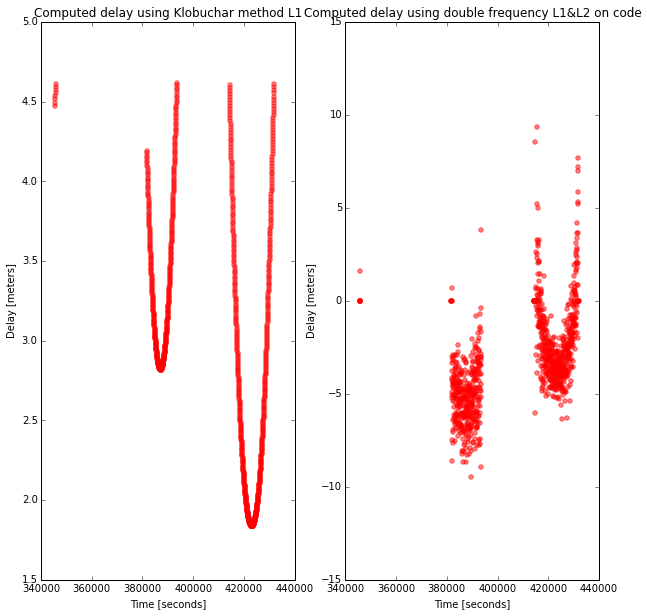

In [217]:
obs="/mnt/flin1210.14o"
nav="/mnt/flin1210.14n"
strsat="GPS 3"
kt,kd=klobuchar(obs,nav,strsat)
__,__,__,__,to,Id_code,Id_phase,__,__=compute_ionodelay([nav],[obs],strsat)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Computed delay using Klobuchar method L1")
plt.xlabel("Time [seconds]")
plt.ylabel("Delay [meters]")
plt.scatter(kt,kd,color="red",alpha=0.5)


plt.subplot(1,2,2)
plt.title("Computed delay using double frequency L1&L2 on code")
plt.xlabel("Time [seconds]")
plt.ylabel("Delay [meters]")
plt.scatter(to,Id_code,color="red",alpha=0.5)


##Comparing double frequency and klobuchar model on a day. All satelites.

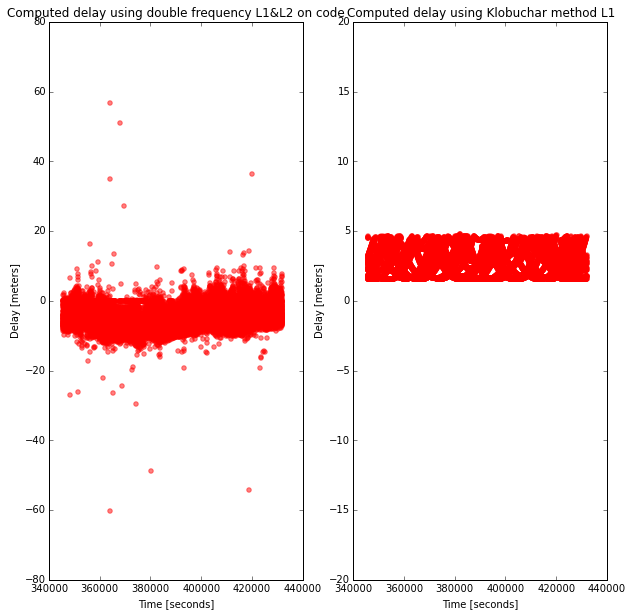

In [221]:
obs="/mnt/flin1210.14o"
nav="/mnt/flin1210.14n"

plt.figure(figsize=(10,10))

__,__,__,__,to,Id_code,Id_phase,__,__=compute_ionodelay([nav],[obs],None)
plt.subplot(1,2,1)
plt.title("Computed delay using double frequency L1&L2 on code")
plt.xlabel("Time [seconds]")
plt.ylabel("Delay [meters]")
#plt.ylim(1,10)
plt.scatter(to,Id_code,color="red",alpha=0.5)

kt,kd=klobuchar(obs,nav,None)
plt.subplot(1,2,2)
plt.title("Computed delay using Klobuchar method L1")
plt.xlabel("Time [seconds]")
plt.ylabel("Delay [meters]")
plt.ylim(-20,20)
plt.scatter(kt,kd,color="red",alpha=0.5)


In [222]:
f1=gpstk.L1_FREQ_GPS
f2=gpstk.L2_FREQ_GPS
alfa=1/((f1**2/f2**2)-1)
print "Gpstk GAMMA: ",gpstk.GAMMA_GPS
print "Our gamma: ",f1**2/f2**2

Gpstk GAMMA:  1.646944444
Our gamma:  1.64694444444


#Compare GPSTK Klobuchar with Klobuchar Implemented

In [ ]:

a=gpstk.IonoCorr().GPSA
b=gpstk.IonoCorr().GPSB
print a,b,gpstk.IonoCorr().param

Ionomodel=nhead.mapIonoCorr
print Ionomodel
print nhead.validIonoCorrGPS

alpha=n[0].ionAlpha #Klobuchar's alpha & beta
beta=n[0].ionBeta

                    